In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

%matplotlib

Using matplotlib backend: TkAgg


In [5]:
data = pd.read_csv('minute_weather.csv')

<h2>Information about the dataset</h2>

Each row in <b>minute_weather.csv</b> contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

<li><b>rowID</b>: unique number for each row (Unit: NA)</li>
<li><b>hpwren_timestamp</b>: timestamp of measure (Unit: year-month-day hour:minute:second)</li>
<li><b>air_pressure</b>: air pressure measured at the timestamp (Unit: hectopascals)</li>
<li><b>air_temp</b>: air temperature measure at the timestamp (Unit: degrees Fahrenheit)</li>
<li><b>avg_wind_direction</b>: wind direction averaged over the minute before the timestamp (Unit: degrees, with 0 means coming from the North, and increasing clockwise)</li>
<li><b>avg_wind_speed</b>: wind speed averaged over the minute before the timestamp (Unit: meters per second)</li>
<li><b>max_wind_direction</b>: highest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and increasing clockwise)</li>
<li><b>max_wind_speed</b>: highest wind speed in the minute before the timestamp (Unit: meters per second)</li>
<li><b>min_wind_direction</b>: smallest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and inceasing clockwise)</li>
<li><b>min_wind_speed</b>: smallest wind speed in the minute before the timestamp (Unit: meters per second)
rain_accumulation: amount of accumulated rain measured at the timestamp (Unit: millimeters)</li>
<li><b>rain_duration</b>: length of time rain has fallen as measured at the timestamp (Unit: seconds)</li>
<li><b>relative_humidity</b>: relative humidity measured at the timestamp (Unit: percent)</li>

In [7]:
data.shape

(1587257, 13)

In [8]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


<b>Data Sampling</b>
<br>Lot's of rows, so lets sample down it by taking every 10th row.

In [9]:
sampled_df = data[(data.rowID % 10) == 0]
sampled_df.shape

(158726, 13)

<b>Statistics</b>
<p>Let's see some statistics of the data</p>

In [10]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937510,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [13]:
sampled_df[sampled_df.rain_accumulation == 0].shape[0]

157812

In [12]:
sampled_df[sampled_df.rain_duration == 0].shape[0]

157237

<h3>Data Preprocessing</h3>

Drop all Rows with Empty rain_duration and rain_accumulation

In [17]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [21]:
sampled_df.dropna(inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<b>Select Features of Interest for custering

In [23]:
sampled_df.columns

Index([u'rowID', u'hpwren_timestamp', u'air_pressure', u'air_temp',
       u'avg_wind_direction', u'avg_wind_speed', u'max_wind_direction',
       u'max_wind_speed', u'min_wind_direction', u'min_wind_speed',
       u'relative_humidity'],
      dtype='object')

In [25]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed','relative_humidity']
select_df = sampled_df[features]

In [27]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


<b>Scale the features using Standard Scalar</b>

In [31]:
X = StandardScaler().fit_transform(select_df)

X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

<h2>Applying the k-means Clustering</h2>

In [33]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

('model\n', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))


Viewing the clusters

In [34]:
centers = model.cluster_centers_
centers

array([[-1.18250526, -0.870469  ,  0.44688125,  1.98314596,  0.53837217,
         1.94404955,  0.90883808],
       [ 0.71696649,  0.44890468,  0.28556521, -0.53644996,  0.47288924,
        -0.54270174, -0.76689962],
       [-0.16370459,  0.8634041 , -1.31126777, -0.58955336, -1.16710698,
        -0.60484116, -0.64125855],
       [ 1.19011715, -0.25505017, -1.15494083,  2.12290738, -1.05345851,
         2.23963146, -1.13446074],
       [-0.70606483,  0.53403399,  0.17519713, -0.58432296,  0.34480629,
        -0.59774954, -0.10775174],
       [-0.83810406, -1.20124616,  0.37556145,  0.36937709,  0.47400789,
         0.35731229,  1.36260251],
       [ 0.23405125,  0.32061871,  1.8879544 , -0.65181511, -1.55175807,
        -0.57669397, -0.28385048],
       [ 0.13261014,  0.84096019,  1.41240254, -0.63819053,  1.67654737,
        -0.58899484, -0.71369989],
       [ 0.24448032, -0.99626438,  0.65792429, -0.54707375,  0.8476937 ,
        -0.5298119 ,  1.16143328],
       [-0.21057014,  0.6329

<h2>Visualizing the results</h2>

In [41]:
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [42]:
def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [43]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-1.182505,-0.870469,0.446881,1.983146,0.538372,1.944050,0.908838,0
1,0.716966,0.448905,0.285565,-0.536450,0.472889,-0.542702,-0.766900,1
2,-0.163705,0.863404,-1.311268,-0.589553,-1.167107,-0.604841,-0.641259,2
3,1.190117,-0.255050,-1.154941,2.122907,-1.053459,2.239631,-1.134461,3
4,-0.706065,0.534034,0.175197,-0.584323,0.344806,-0.597750,-0.107752,4
5,-0.838104,-1.201246,0.375561,0.369377,0.474008,0.357312,1.362603,5
6,0.234051,0.320619,1.887954,-0.651815,-1.551758,-0.576694,-0.283850,6
7,0.132610,0.840960,1.412403,-0.638191,1.676547,-0.588995,-0.713700,7
8,0.244480,-0.996264,0.657924,-0.547074,0.847694,-0.529812,1.161433,8
9,-0.210570,0.632971,0.408564,0.733538,0.516734,0.671688,-0.151676,9


<h2>Dry Days</h2>

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  after removing the cwd from sys.path.


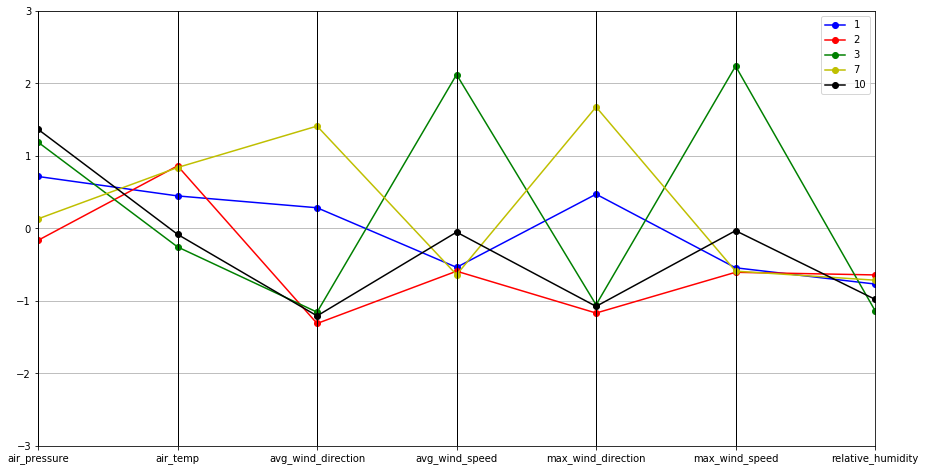

In [44]:
parallel_plot(P[P['relative_humidity'] < -0.5])

<h2>Warm Days</h2>

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  after removing the cwd from sys.path.


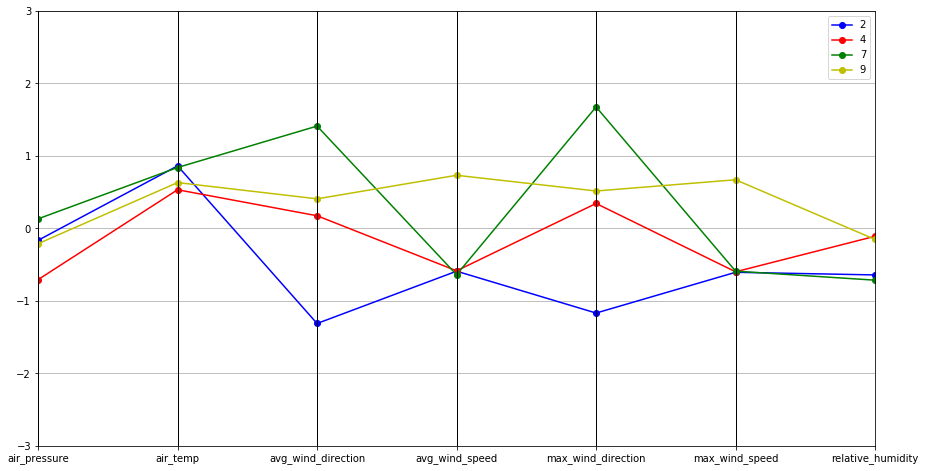

In [45]:
parallel_plot(P[P['air_temp'] > 0.5])


<h2>Cool Days</h2>

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  after removing the cwd from sys.path.


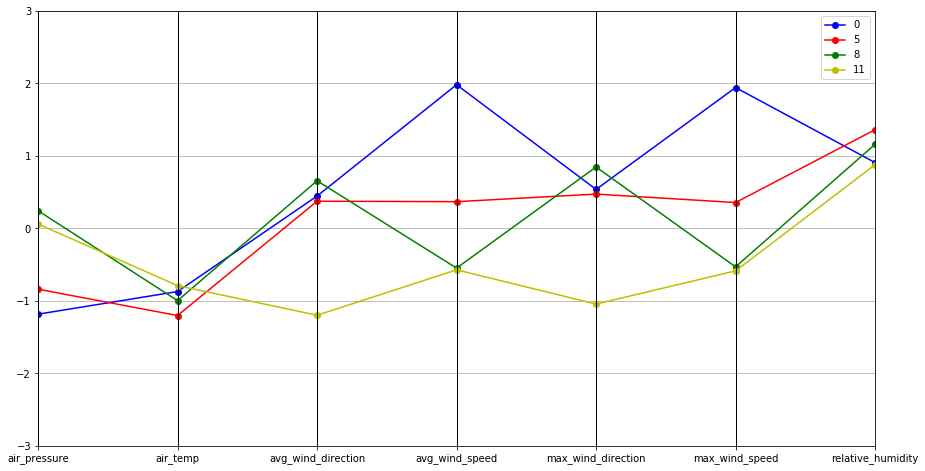

In [47]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])